# Regression Evaluation

In [1]:
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydataset
import scipy.stats as stats
import sklearn.metrics
from statsmodels.formula.api import ols

/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Punchline: is our model better than the model that just predicts the average?

The best model we can make with no additional information: $\hat{y} = \bar{y}$

## Setup / Functions

In [17]:
def residuals(actual, predicted):
    return predicted - actual

def sse(actual, predicted):
    return (residuals(actual, predicted) ** 2).sum()

def mse(actual, predicted):
    n = actual.shape[0]
    return sse(actual, predicted) / n

def rmse(actual, predicted):
    return math.sqrt(mse(actual, predicted))

def ess(actual, predicted):
    return ((predicted - actual.mean()) ** 2).sum()

def tss(actual):
    return ((actual - actual.mean()) ** 2).sum()

In [16]:
def r2_score(actual, predicted):
    return ess(actual, predicted) / tss(actual)

In [26]:
def plot_residuals(actual, predicted):
    residuals = actual - predicted
    plt.hlines(0, actual.min(), actual.max(), ls=':')
    plt.scatter(actual, residuals)
    plt.ylabel('residual ($y - \hat{y}$)')
    plt.xlabel('actual value ($y$)')
    plt.title('Actual vs Residual')
    return plt.gca()

def regression_errors(actual, predicted):
    return pd.Series({
        'sse': sse(actual, predicted),
        'ess': ess(actual, predicted),
        'tss': tss(actual),
        'mse': mse(actual, predicted),
        'rmse': rmse(actual, predicted),
    })

def baseline_mean_errors(actual):
    predicted = actual.mean()
    return {
        'sse': sse(actual, predicted),
        'mse': mse(actual, predicted),
        'rmse': rmse(actual, predicted),
    }

def better_than_baseline(actual, predicted):
    sse_baseline = sse(actual, actual.mean())
    sse_model = sse(actual, predicted)
    return sse_model < sse_baseline

def model_significance(ols_model):
    return {
        'r^2 -- variance explained': ols_model.rsquared,
        'p-value -- P(data|model == baseline)': ols_model.f_pvalue,
    }

## Use the Functions

### tips

In [4]:
tips = pydataset.data('tips')
model = ols('tip ~ total_bill', tips).fit()

In [11]:
# we can use the fit model on new data
new_data = pd.Series([10, 20], name='total_bill')
model.predict(new_data)

0    1.970515
1    3.020760
dtype: float64

In [18]:
actual = tips.tip
predicted = model.predict()

In [20]:
model2 = ols('tip ~ size', tips).fit()
predicted2 = model2.predict()

In [21]:
regression_errors(actual, predicted2)

{'sse': 353.83442669898386,
 'ess': 111.37805035019645,
 'tss': 465.2124770491804,
 'mse': 1.4501410930286225,
 'rmse': 1.2042180421454507}

In [19]:
regression_errors(actual, predicted)

{'sse': 252.788743850776,
 'ess': 212.4237331984043,
 'tss': 465.2124770491804,
 'mse': 1.036019442011377,
 'rmse': 1.0178504025697377}

In [23]:
regression_errors(actual, predicted)['sse'] < regression_errors(actual, predicted2)['sse']

True

In [24]:
better_than_baseline(actual, predicted)

True

In [27]:
# we can convert a dictionary to a pandas series easily
regression_errors(actual, predicted)

sse     252.788744
ess     212.423733
tss     465.212477
mse       1.036019
rmse      1.017850
dtype: float64

In [28]:
pd.DataFrame({
    'model 1 (tip ~ total_bill)': regression_errors(actual, predicted),
    'model 2 (tip ~ size)': regression_errors(actual, predicted2),
})

,model 1 (tip ~ total_bill),model 2 (tip ~ size)
sse,252.788744,353.834427
ess,212.423733,111.378050
tss,465.212477,465.212477
mse,1.036019,1.450141
rmse,1.017850,1.204218


In [30]:
model_significance(model)

{'r^2 -- variance explained': 0.45661658635167657,
 'p-value -- P(data|model == baseline)': 6.692470646863209e-34}

In [33]:
sklearn_r2 = sklearn.metrics.r2_score(actual, predicted)

In [34]:
our_r2 = r2_score(actual, predicted)

In [35]:
our_r2 == sklearn_r2

False

In [37]:
our_r2, sklearn_r2

(0.4566165863516763, 0.45661658635167657)

In [36]:
np.isclose(our_r2, sklearn_r2)

True

In [38]:
print('our mse', mse(actual, predicted))
print('sklearn', sklearn.metrics.mean_squared_error(actual, predicted))

our mse 1.036019442011377
sklearn 1.036019442011377


In [39]:
%%timeit

mse(actual, predicted)

638 µs ± 74.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [40]:
%%timeit

sklearn.metrics.mean_squared_error(actual, predicted)

298 µs ± 10.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### mpg

In [41]:
mpg = pydataset.data('mpg')

In [42]:
model = ols('hwy ~ displ', mpg).fit()

In [43]:
actual = mpg.hwy # y
predicted = model.predict() # yhat

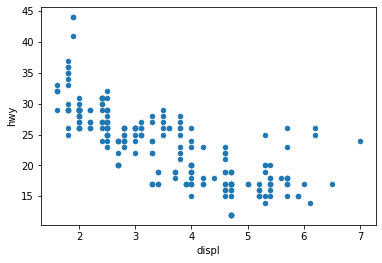

In [47]:
mpg.plot.scatter(y='hwy', x='displ')

In [44]:
regression_errors(actual, predicted)

sse     3413.829009
ess     4847.833384
tss     8261.662393
mse       14.589013
rmse       3.819557
dtype: float64

In [45]:
model_significance(model)

{'r^2 -- variance explained': 0.5867866723989039,
 'p-value -- P(data|model == baseline)': 2.0389744555910457e-46}

In [46]:
better_than_baseline(actual, predicted)

True

## More on Visualizing Residuals

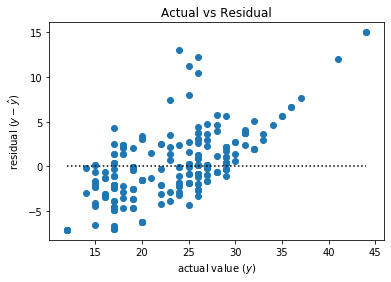

In [48]:
plot_residuals(actual, predicted)

In [49]:
def plot_residuals(actual, predicted):
    residuals = actual - predicted

    fig, axs = plt.subplots(2, 2, figsize=(12, 12))
    axs[0, 0].hist(residuals, bins=20, ec='black', fc='white')
    axs[0, 0].set(title="Distribution of Residuals")

    axs[0, 1].scatter(actual, predicted, marker='.', c='firebrick')
    axs[0, 1].plot([actual.min(), actual.max()], [actual.min(), actual.max()], ls=':', color='black')
    axs[0, 1].set(title="Actual vs Predicted", xlabel="$y$", ylabel=r"$\hat{y}$")

    axs[1, 0].scatter(actual, residuals, marker='.', c='firebrick')
    axs[1, 0].hlines(0, actual.min(), actual.max(), ls=':', color='black')
    axs[1, 0].set(title="Actual vs Residuals", xlabel="$y$", ylabel=r"$y - \hat{y}$")

    axs[1, 1].scatter(predicted, residuals, marker='.', c='firebrick')
    axs[1, 1].hlines(0, actual.min(), actual.max(), ls=':', color='black')
    axs[1, 1].set(
        title="Predicted vs Residuals", xlabel=r"$\hat{y}$", ylabel=r"$y - \hat{y}$"
    )

    return fig, axs

(<Figure size 864x864 with 4 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12c3de5c0>,
       dtype=object))

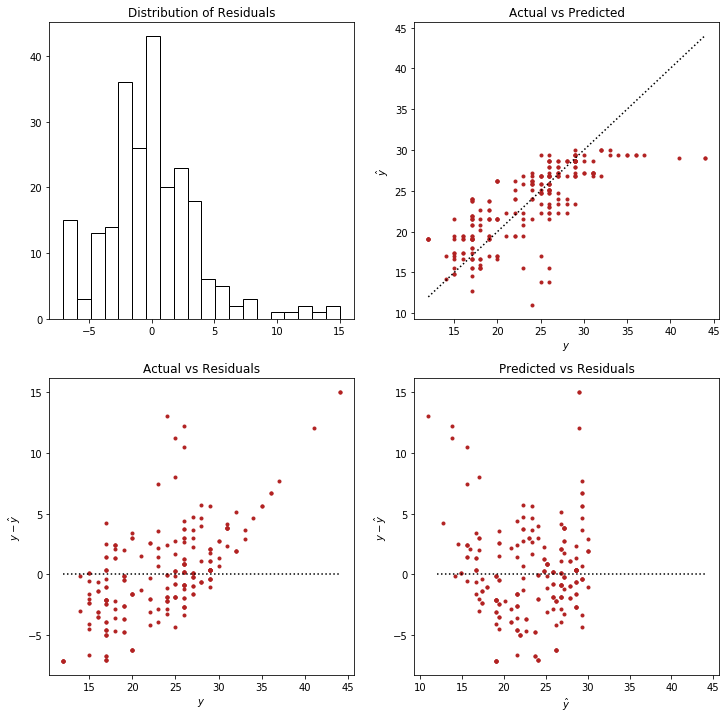

In [50]:
plot_residuals(actual, predicted)

Text(0.5, 1.0, 'This is what random noise looks like?')

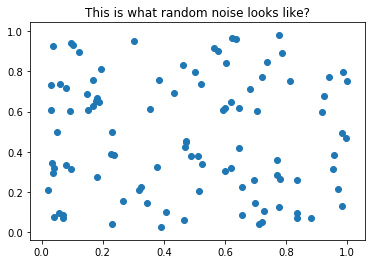

In [54]:
plt.scatter(np.random.uniform(size=100), np.random.uniform(size=100))
plt.title('This is what random noise looks like?')